In [ ]:
'''BMED318. Hands-on. Chapter 7. Frequency Filtering 
아래 내용을 수행하여 과정과 결과를 보고서형식으로 작성한 후, 실행에 필요한 모든 파일과 함께 zip 압
축하여 제출하시오. 제출 시 학번, 이름 반드시 기입하세요. 

'''
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as tr


def imgray(image_list):
    fig = plt.figure()
    for i in range(len(image_list)):
        plt.subplot(1,len(image_list),i+1)
        plt.imshow(image_list[i], cmap='gray')
        plt.axis('off')
    #plt.show()
    return fig

def make_grid2d(size):
    grid = np.linspace(-(size//2), (size//2), size)
    xx,yy = np.meshgrid(grid, grid)
    return xx,yy

def make_gaussian_mask2d(size, sigma):
    xx,yy = make_grid2d(size)
    mask2d = np.exp(-(xx**2 + yy**2) / (2*sigma**2))
    mask2d /= np.sum(mask2d)
    return mask2d

def surface_plot(x,y,z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x,y,z, cmap='gray')
    ax.plot_wireframe(x,y,z, color='k', linewidth=0.5)
    plt.show()

In [ ]:
'''
1. Prepare input image.  
a) Read ‘skull.jpg’. Name the skull image array as im. 
b) Resize the im to 226x187. '''
# a)
im = plt.imread('skull.jpg')
# b)
im = tr.resize(im, output_shape=(226,187), preserve_range=True)

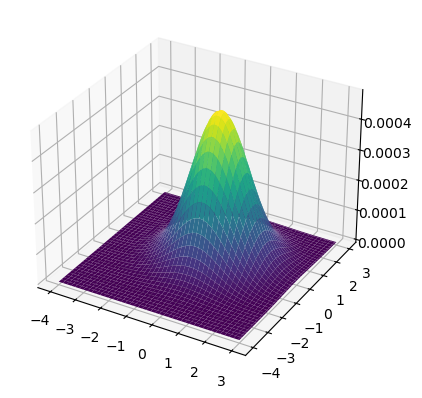

In [ ]:
''' 
2. Prepare a spatial domain filter. 
a) Make 8x8 Gaussian filter with sigma=1.0 Name the filter array as lpf. 
b) Show the surface plot of lpf. The size of 8x8 filter mask is too small to make it look decent.
    Increase the number of samples (64x64 or 128x128, etc) before you plot the filter mask.
(미려하게 보이기 위해서 이 단계에서만 이렇게 하면 됨. 실제 아래에서는 계속 8x8 필터마스크를 사용함) 
'''
# a
lpf = make_gaussian_mask2d(8, 1.0)
# b
sigma_plot = 1.0
size_plot = 128
grid_plot = np.linspace(-(8//2), (8//2 -1), size_plot)
xx_plot, yy_plot = np.meshgrid(grid_plot, grid_plot)
lpf_128 = np.exp(-(xx_plot**2 + yy_plot**2) / (2*sigma_plot**2))
lpf_128 /= np.sum(lpf_128)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx_plot, yy_plot, lpf_128, cmap='viridis')
plt.show()

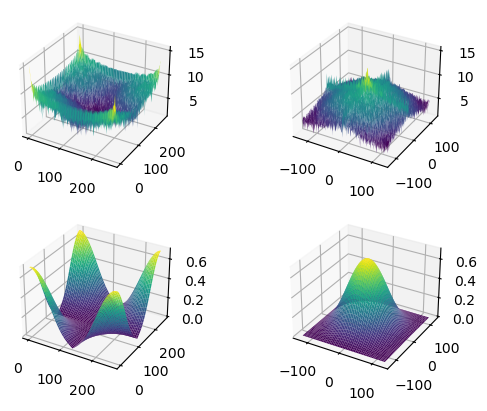

In [ ]:
from numpy import fft

'''
3. Get Fourier spectrums.  
a) Zero-padding for the skull image: Make 256x256 zero matrix imz.
    Copy im to imz at the same pixel locations.  
b) Zero-padding for the gaussian filter: Make 256x256 zero matrix lpfz.
    Copy the filter lpf to lpfz at the same pixel locations.  
c) What is the most appropriate size of zero-padded array for this example? Explain the reason. 
d) Do Fourier transform imz and lpfz and store the results into IMZ and LPFZ respectively.  
e) The DC coefficients of IMZ and LPFZ are located at the index [0,0].
    Circular-shift the arrays so that the DC coefficients should be located at center of the array.
    Name the resultant arrays as IMZ_CS and LPFZ_CS respectively.  
f) Display the magnitudes of IMZ, IMZ_CS, LPFZ, and LPFZ_CS as surface plots.  

'''
# a
pad_size = (256,256)
imz = np.zeros(pad_size)
imz[0:im.shape[0], 0:im.shape[1]] = im

# b
lpfz = np.zeros(pad_size)
lpfz[0:lpf.shape[0], 0:lpf.shape[1]] = lpf

# c
'''
aliasing 오류를 방지하기 위해선
이미지 크기가 (M,N)=(226,187)이고 필터 크기가 (m,n)=(8,8)일 때
선형 컨벌루션 결과의 크기는 (M+m-1, N+n-1) = (226+8-1, 187+8-1) = (233, 194)가 됩니다.
따라서 최소한 (233,194) 크기 이상으로 두 신호를 제로 패딩해야합니다.
이때 FFT 알고리즘이 가장 효율적으로 동작하는 크기는 2의 거듭제곱의 크기이므로,
가장 적절한 제로 패딩 크기는 (256,256)입니다.
'''
# d
IMZ = np.fft.fft2(imz)
LPFZ = np.fft.fft2(lpfz)

# e
IMZ_CS = np.fft.fftshift(IMZ)
LPFZ_CS = np.fft.fftshift(LPFZ)

# f
U_ns = np.arange(pad_size[1])
V_ns = np.arange(pad_size[0])
UU_ns, VV_ns = np.meshgrid(U_ns, V_ns)
U_s = np.arange(-pad_size[1]//2, pad_size[1]//2)
V_s = np.arange(-pad_size[0]//2, pad_size[0]//2)
UU_s, VV_s = np.meshgrid(U_s, V_s)

mag_IMZ = np.log(1 + np.abs(IMZ))
mag_IMZ_CS = np.log(1 + np.abs(IMZ_CS))
mag_LPFZ = np.log(1 + np.abs(LPFZ))
mag_LPFZ_CS = np.log(1 + np.abs(LPFZ_CS))

fig = plt.figure()
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_surface(UU_ns, VV_ns, mag_IMZ, cmap='viridis', rstride=5, cstride=5)
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_surface(UU_s, VV_s, mag_IMZ_CS, cmap='viridis', rstride=5, cstride=5)
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_surface(UU_ns, VV_ns, mag_LPFZ, cmap='viridis', rstride=5, cstride=5)
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_surface(UU_s, VV_s, mag_LPFZ_CS, cmap='viridis', rstride=5, cstride=5)

plt.show()

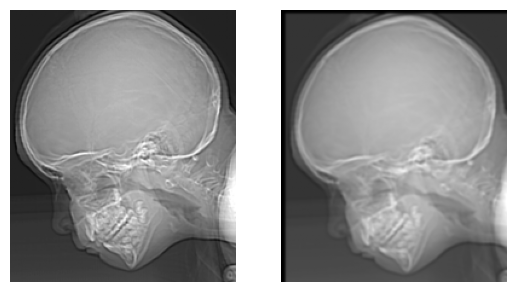

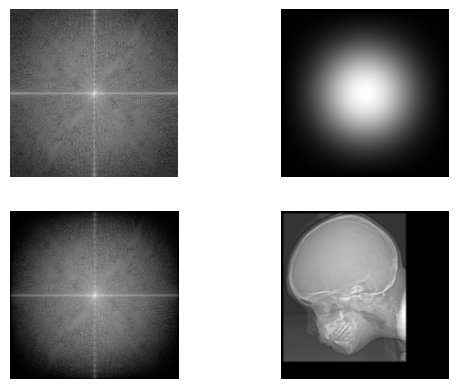

In [ ]:
'''
4. Frequency domain filtering: LPF 
강의자료에서 설명한 바와 같이 위의 그림의 절차대로 im(그림에서 f),
imz 와 lpfz를 이용하여 frequency filtering을 수행하시오. 중간결과들과 최종결과를
위의 그림 순서대로 나열하되 크기가 같은 그림끼리 모아서 보이시오.
- 첫 figure: f와 g, 둘째 figure: fp부터 IDFT결과까지 보이면 됨.
subplot()을 사용시 일부 그림이 깨진 것처럼 보이면 figure window의 크기를 확대해주면 정상적으로 결과가 보임.
subplot()을 사용하지 않을 경우 독립 figure로 만든 후 보고서에 위의 순서로 배열해서 보여주면 됨.
- frequency spectrum 은 magnitude 만 보여주면 됨. 
- 그림의 Fp,H, HFp 등 frequency spectrum은 log scale로 보이시오.
- IDFT후 복소수가 나오면 실수만 취하여 결과영상을 만드시오. 
'''
IMZ_LPF = IMZ*LPFZ
imz_lpf = np.fft.ifft2(IMZ_LPF)
g_padded = np.real(imz_lpf)
g_final = g_padded[0:im.shape[0], 0:im.shape[1]]

plt.figure()
plt.subplot(121)
plt.imshow(im, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(g_final, cmap='gray')
plt.axis('off')
plt.show()


F_to_show = mag_IMZ_CS
H_to_show = mag_LPFZ_CS
HF_to_show = np.log(1+ np.abs(np.fft.fftshift(IMZ_LPF)))
g_to_show = g_padded
plt.figure()
plt.subplot(221)
plt.imshow(F_to_show, cmap='gray')
plt.axis('off')
plt.subplot(222)
plt.imshow(H_to_show, cmap='gray')
plt.axis('off')
plt.subplot(223)
plt.imshow(HF_to_show, cmap='gray')
plt.axis('off')
plt.subplot(224)
plt.imshow(g_to_show, cmap='gray')
plt.axis('off')
plt.show()

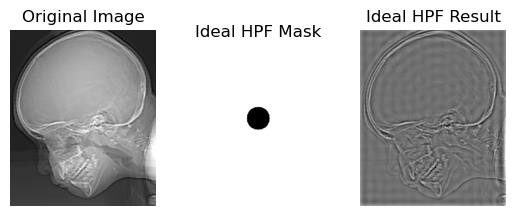

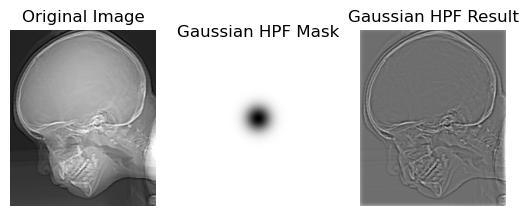

In [ ]:
'''
5. Frequency domain filtering: HPF 
4번에서 수행한 frequency domain filtering을 수행하는 코드를 function으로 만든 후 아래 과정에 반복 
사용하시오. 
a) im에 대하여 ideal HPF를 적용하여 두개골과 얼굴의 외곽선 edge가 모두 선명하게 나오는 filter 
radius (cutoff frequency)를 제시하시오. 실험을 통하여 가장 적합한 값을 제시하고 입력영상과 함께 
최종 결과영상을 보이시오. 
b) im에 대하여 Gaussian HPF를 적용하고 두개골과 얼굴의 외곽선 edge가 모두 선명하게 나오는 
standard deviation을 제시하시오. 실험을 통하여 가장 적합한 값을 제시하고 입력영상과 함께 최종 
결과영상들을 보이시오. 
정답은 없습니다. 본인의 관찰과 판단에 의거하여 최적값을 제시하고 그 이유를 설명하면 됩니다.  
'''
# a
def freq_filter_H(im_in, H_filter):
    M,N = im_in.shape
    P,Q = H_filter.shape
    imz_in = np.zeros((P,Q))
    imz_in[0:M, 0:N] = im_in
    IMZ_in = np.fft.fft2(imz_in)
    IMZ_in_CS = np.fft.fftshift(IMZ_in)
    IMZ_filtered_CS = IMZ_in_CS*H_filter
    IMZ_filtered = np.fft.ifftshift(IMZ_filtered_CS)
    imz_filtered = np.fft.ifft2(IMZ_filtered)
    g_padded_out = np.real(imz_filtered)
    g_final_out = g_padded_out[0:M, 0:N]
    return g_final_out
    
size_H = pad_size[0]
grid_H = np.arange(-size_H//2, size_H//2)
U,V = np.meshgrid(grid_H, grid_H)
D = np.sqrt(U**2 + V**2)
D0_ideal = 20
ideal_hpf_mask = (D>D0_ideal).astype(float)
im_ideal_hpf = freq_filter_H(im, ideal_hpf_mask)
"""
D0 = 20 으로 설정했습니다.
D0가 10 이하로 너무 작으면 대부분의 저주파 성분이 차단되어 외곽선이 강해지지만
ringing artifact가 심하게 나타납니다.
D0가 50처럼 너무 크면 저주파 성분이 많이 통과되어 외곽선이 흐릿해지고
원본 이미지와 비슷해져 HPF의 의미가 약해집니다.
D0 = 20은 링잉 현상이 다소 존재하지만 두개골과 얼굴의 주요 외곽선을 선명하게 잘 추출합니다.
"""
fig1 = imgray([im, ideal_hpf_mask, im_ideal_hpf])
axes1 = fig1.get_axes()
axes1[0].set_title('Original Image')
axes1[1].set_title('Ideal HPF Mask')
axes1[2].set_title('Ideal HPF Result')
plt.show()

# b
sigma_gauss = 15 # 실험적으로 선택한 값

gauss_hpf_mask = 1 - np.exp(-(D**2) / (2 * sigma_gauss**2))
im_gauss_hpf = freq_filter_H(im, gauss_hpf_mask)
#plt.show()

"""
[Gaussian HPF 관찰 및 판단]
sigma = 15 로 설정했습니다.
- 가우시안 필터는 Ideal 필터와 달리 경계가 부드러워 링잉 현상이 발생하지 않습니다[cite: 1323].
- sigma = 10처럼 너무 작으면: 필터의 차단 경계가 너무 넓어(부드러워) 
  필요한 edge 성분까지 일부 제거되어 이미지가 전반적으로 어두워집니다.
- sigma = 40처럼 너무 크면: 저주파 차단 효과가 약해져 외곽선이 선명하지 않고 
  원본의 음영이 많이 남습니다.
- sigma = 15는 링잉 현상 없이 두개골과 얼굴의 외곽선을 
  비교적 선명하고 자연스럽게 강조합니다.
"""

fig2 = imgray([im, gauss_hpf_mask, im_gauss_hpf])
axes2 = fig2.get_axes()
axes2[0].set_title('Original Image')
axes2[1].set_title('Gaussian HPF Mask')
axes2[2].set_title('Gaussian HPF Result')
plt.show()